In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import jax
import jax.numpy as jnp
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import flax.linen as nn

from sklearn.datasets import make_moons
from rebayes_mini import callbacks
from functools import partial
from rebayes_mini.methods.gauss_filter import KalmanFilter

In [5]:
%config InlineBackend.figure_format = "retina"
plt.rcParams["font.size"] = 15
plt.rcParams["lines.linewidth"] = 2
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False
plt.rc("text", usetex=True)

sns.set_palette("colorblind")
palette = sns.color_palette()

In [6]:
@partial(jax.vmap, in_axes=(None, 0))
def get_segment_init(segment, n):
    return jnp.where(segment == n, size=len(segment))[0][0] 

In [7]:
p_change = 0.005
p_change = 0.01

def step(params, key):
    key_x, key_y, key_change, key_params = jax.random.split(key, 4)

    change = jax.random.uniform(key_change) < p_change

    key_theta0, key_theta1, key_theta2 = jax.random.split(key_params, 3)
    params_change = jax.random.uniform(key_params, (3,), minval=-3, maxval=3)
    # theta0 = jax.random.uniform(key_theta0, (1,), minval=-3, maxval=3)
    # theta1 = jax.random.uniform(key_theta1, (1,), minval=-3, maxval=3)
    # theta2 = jax.random.uniform(key_theta2, (1,), minval=-3, maxval=3)
    # params_change = jnp.concat([theta0, theta1, theta2])
    
    params = params * (1 - change) + params_change * change

    x = jax.random.uniform(key_x, minval=-2, maxval=2)
    x = jnp.c_[1, x, x ** 2]
    
    yclean = x @ params
    # y = yclean + jax.random.t(key_y, df=2.01)
    y = yclean + jax.random.normal(key_y)

    out = {
        "params": params,
        "y": y,
        "x": x,
        "yclean": yclean,
        "change": change,
    }

    return params, out

In [8]:
key = jax.random.PRNGKey(31)
key = jax.random.PRNGKey(27)
# key = jax.random.PRNGKey(27182)

In [9]:
n_samples = 300
keys = jax.random.split(key, n_samples)
theta_init = jnp.array([1.0, 1.0, 1.0])

_, hist = jax.lax.scan(step, theta_init, keys)
hist = jax.tree.map(np.array, hist)

In [10]:
segment = hist["change"].cumsum()

n_segments = len(np.unique(segment))
n_segments

6

In [11]:
n_segments = len(np.unique(segment))
segments_init = get_segment_init(segment, jnp.arange(n_segments))
segments_init = np.array(segments_init)

In [12]:
cmap = {
    # s: plt.cm.tab10(s)
    s: sns.color_palette()[s]
    for s in range(n_segments)
}

colors = [cmap[s] for s in segment]

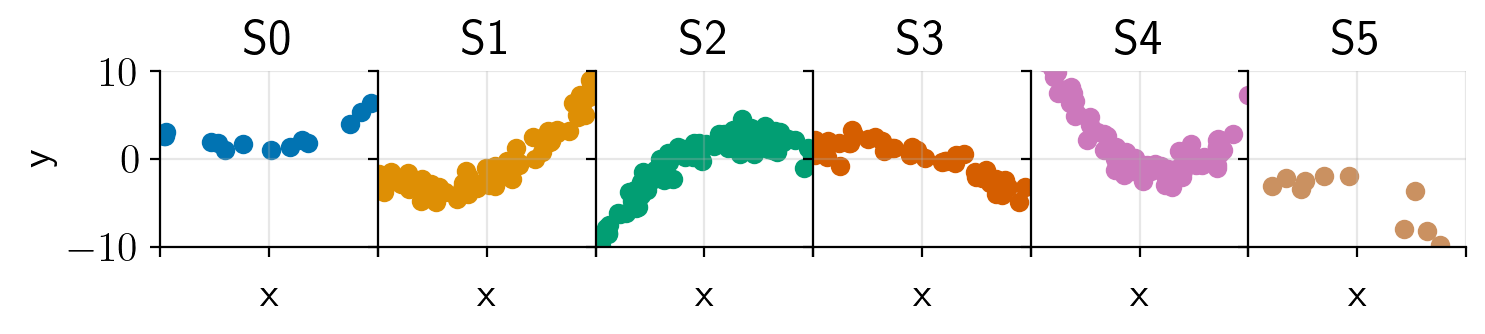

In [13]:
fig, axs = plt.subplots(1, n_segments, sharey=True, figsize=(6.4 * 1.2, 4.8 * 0.4))
axs = axs.ravel()
    
for n in np.arange(n_segments):
    axs[n].set_title(f"S{n}")
    color = cmap[n]
    ixs = jnp.where(segment == n)[0]
    xsub = hist["x"][ixs, :, 1]
    ysub = hist["y"][ixs]
    axs[n].scatter(xsub, ysub, color=color)
    axs[n].grid(alpha=0.3)
    axs[n].set_xlabel("x")
    axs[n].set_xlim(-2, 2)
    axs[n].set_ylim(top=10, bottom=-10)
    axs[n].set_xticks([-2, 0, 2], labels=["", "", ""])

axs[0].set_ylabel("y")
plt.tight_layout()
plt.subplots_adjust(wspace=0.0)

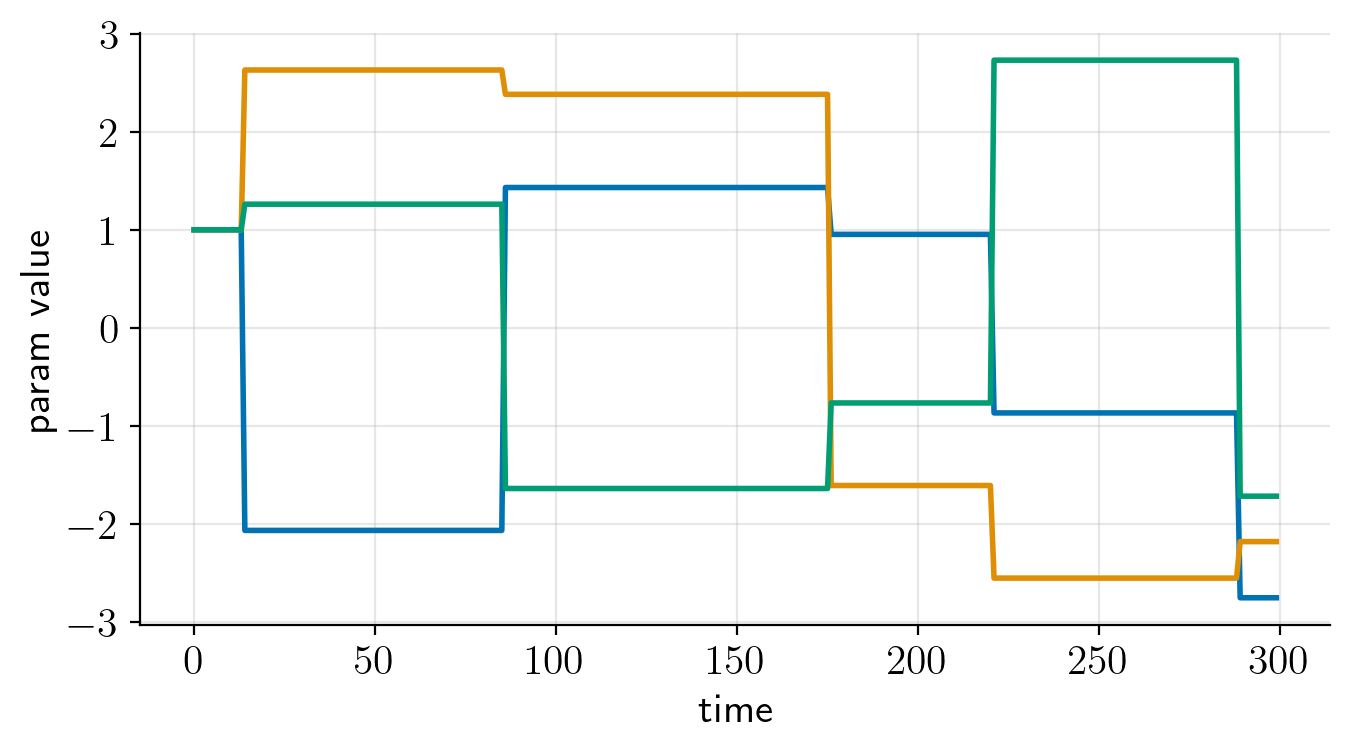

In [22]:
fig, ax = plt.subplots(figsize=(6.4 * 1.2, 4.8 * 0.8))
plt.xlabel("time")
plt.ylabel("param value")
plt.plot(hist["params"])
plt.grid(alpha=0.3)

In [56]:
X = jnp.array(hist["x"])
y = jnp.array(hist["y"])

## Filtering

In [71]:
from rebayes_mini.callbacks import get_predicted_mean

In [72]:
kf = KalmanFilter()

In [104]:
mean_init = jnp.zeros(3)
Q = jnp.eye(3) * 0.01
R = jnp.eye(1)
F = jnp.eye(3)
bel_init = kf.init_bel(mean_init, Q, R, F)

In [105]:
_, mean_hist = kf.scan(bel_init, y, X, get_predicted_mean)

In [106]:
X.shape

(300, 1, 3)

In [107]:
preds = jnp.einsum("tim,tm->t", X, mean_hist)

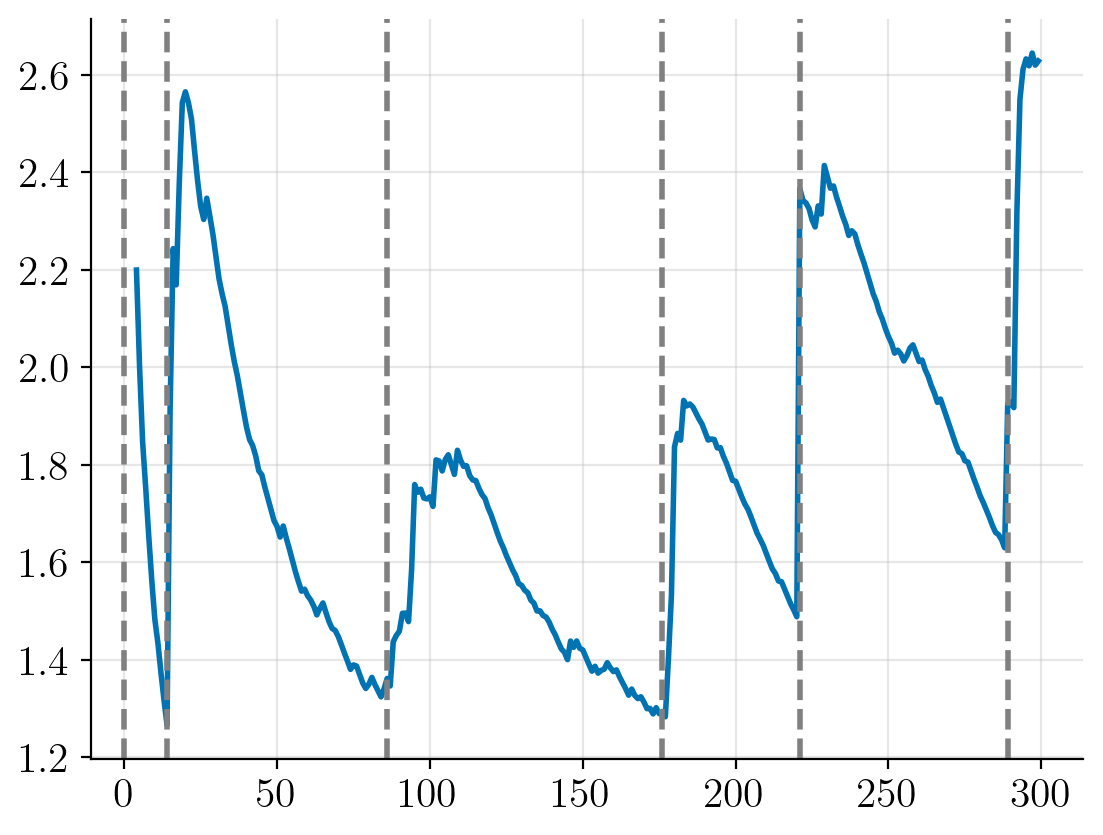

In [126]:
errs = np.array(preds - y.squeeze())
errs = pd.Series(errs)
np.sqrt(np.power(errs, 2).ewm(span=100, min_periods=5).mean()).plot()
for s in segments_init:
    plt.axvline(x=s, c="gray", linestyle="--")
plt.grid(alpha=0.3)

## Varying $Q_t$

In [190]:
kf = KalmanFilter()

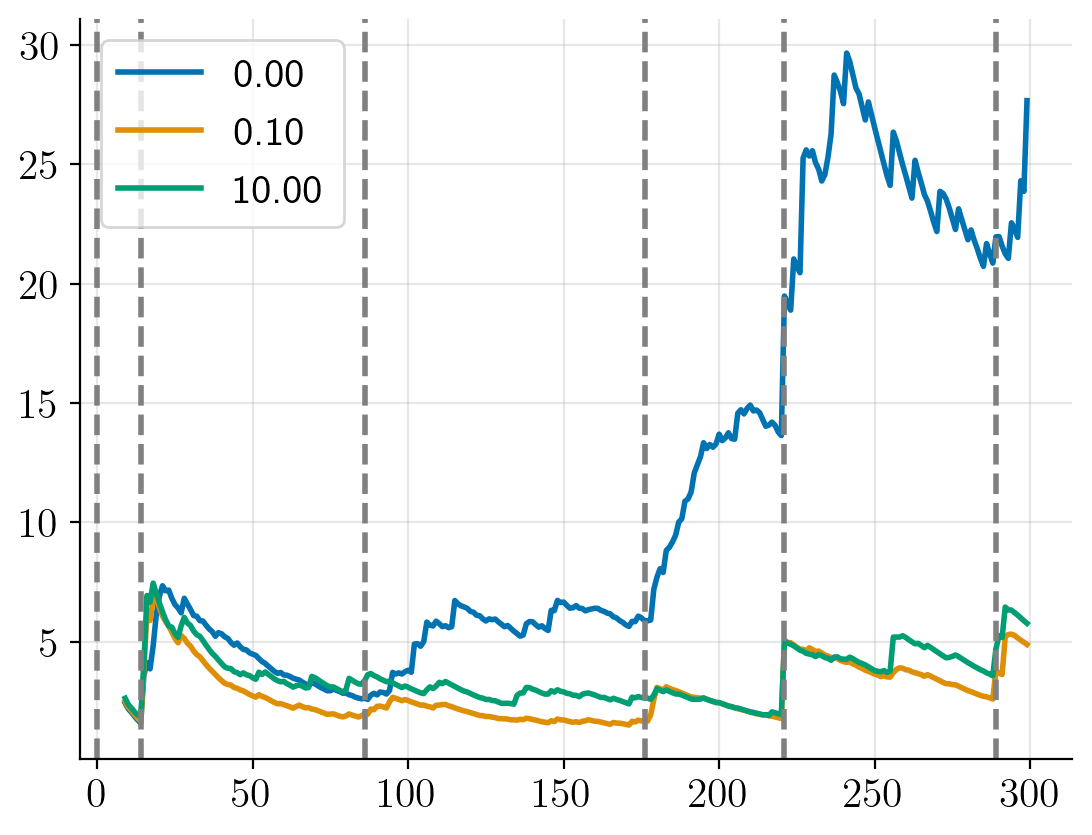

In [195]:
mean_init = jnp.zeros(3)
R = jnp.eye(1)
F = jnp.eye(3)

errs_final = []
q_values = [0.0, 0.1, 10.0]
for q in q_values:
    Q = jnp.eye(3) * q
    bel_init = kf.init_bel(mean_init, Q, R, F)
    
    _, mean_hist = kf.scan(bel_init, y, X, get_predicted_mean)
    
    X.shape
    
    preds = jnp.einsum("tim,tm->t", X, mean_hist)
    
    errs = np.array(preds - y.squeeze())
    errs = pd.Series(errs)
    np.power(errs, 2).ewm(span=100, min_periods=10).mean().plot(label=f"{q:0.2f}")
    err_total = jnp.sqrt(np.power(errs, 2).mean())
    errs_final.append(err_total)
plt.legend()

for s in segments_init:
    plt.axvline(x=s, c="gray", linestyle="--")
plt.grid(alpha=0.3)

In [187]:
mean_init = jnp.zeros(3)
R = jnp.eye(1)
F = jnp.eye(3)

errs_final = []
q_values = np.logspace(-2.5, 2, num=20)
for q in q_values:
    Q = jnp.eye(3) * q
    bel_init = kf.init_bel(mean_init, Q, R, F)
    
    _, mean_hist = kf.scan(bel_init, y, X, get_predicted_mean)
    
    preds = jnp.einsum("tim,tm->t", X, mean_hist)
    
    errs = np.array(preds - y.squeeze())
    errs = pd.Series(errs)
    err_total = jnp.sqrt(np.power(errs, 2).mean())
    
    errs_final.append(err_total)
errs_final = np.array(errs_final)

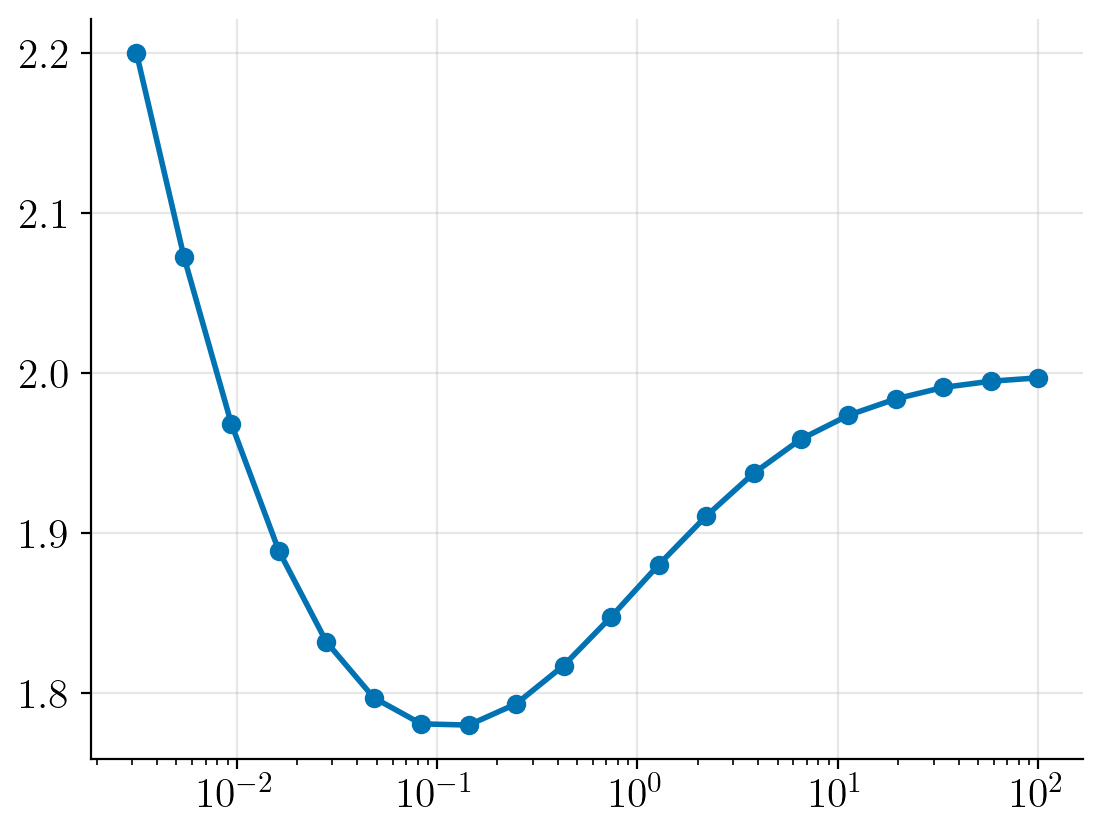

In [188]:
plt.plot(q_values, errs_final, marker="o")
plt.xscale("log")
plt.grid(alpha=0.3)